# Model Sensitivity Analysis
Maximizing the ELBO is a non-convex optimization problem. The parameters estimate are sensitive to the choice of their initial estimates. Hence, we further evaluate the chosen set of hyperparameters for 50 random initialization and then select the best model out of it. 

Stages of the Analysis
 + Python script for variational posterior computation: **model_sensitivity_fit.py**
 + Script to evaluate the model for 50 random initialization: **mem_model_sensitivity**
 + Analysis of the output based on in sample $LLPD$
 

#### Script to evaluate the model
We have saved the command for calling the python script for parameter estimation in the file **mem_model_sensitivity**.

A line in the file **mem_model_sensitivity** calls the python script **model_sensitivity_fit.py** for a given choice of the parameters. 

*module purge ; module load slurm gcc python3 ; omp_num_threads=1 python3 model_sensitivity_fit.py 100.0 50 0.219 0.06503 0.0 50 200 > logfile/50.log 2>&1*

#### Parameter estimation 
We run the script on server using the command:
*sbatch -N [#node] -p [#partition] disBatch.py -t [#task on each node] [script_file]*

Example: *sbatch -N 2 -p ccm disBatch.py -t 25 mem_model_sensitivity*



#### Model output analysis
Let us consider out model output is saved in the folder **MMSens**. We load each of the output file, compute the $LLPD$ on  full data and select the model with the largest LLPD. 


In [ ]:
## Load all the required python module for the analysis 
import glob 
import pickle as pkl 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hiplot as hip
import os 
import copy 
%matplotlib inline

# 1. Read config_mode.txt
config_file = "config_mode.txt"
if os.path.exists(config_file):
    with open(config_file, "r") as f:
        lines = f.read().splitlines()
        data = lines[0].strip() if len(lines) > 0 else "original"
        setting = int(lines[1]) if len(lines) > 1 else 1
else:
    data = "original"
    setting = 1

# 2. Set plots folder based on config
if data == "original" and setting == 1: 
    figfol = "./plots1/"
elif data == "original" and setting == 2:
    figfol = "./plots2/"
elif data == "new" and setting == 2: 
    figfol = "./plots3/"

if not os.path.exists(figfol):
    os.makedirs(figfol)
    print(f"✅ Created folder: {figfol}")
else:
    print(f"📂 Folder already exists: {figfol}")

if data == "original" and setting == 1:
    fname_o = glob.glob('../results/results_old_c/sensitivity/models/*model_nb_cvtest.pkl')
elif data == "original" and setting ==2: 
    fname_o = glob.glob('../results/results_old_nc/sensitivity/models/*model_nb_cvtest.pkl') 
elif data =="new" and setting ==2: 
    fname_o = glob.glob('../results/results_new_var_nc/sensitivity/models/*model_nb_cvtest.pkl') 
elif data =="new" and setting ==1: 
    fname_o = glob.glob('../results/results_new_var_c/sensitivity/models/*model_nb_cvtest.pkl') 
print("Looking for files in:", fname_o)
print("Loaded files:", fname_o) #Check if the file is loaded


📂 Folder already exists: ./plots2/
Looking for files in: ['../results/results_new/sensitivity/models/18_79_model_nb_cvtest.pkl', '../results/results_new/sensitivity/models/18_74_model_nb_cvtest.pkl', '../results/results_new/sensitivity/models/18_64_model_nb_cvtest.pkl', '../results/results_new/sensitivity/models/18_90_model_nb_cvtest.pkl', '../results/results_new/sensitivity/models/18_71_model_nb_cvtest.pkl', '../results/results_new/sensitivity/models/18_82_model_nb_cvtest.pkl', '../results/results_new/sensitivity/models/18_69_model_nb_cvtest.pkl', '../results/results_new/sensitivity/models/18_62_model_nb_cvtest.pkl', '../results/results_new/sensitivity/models/18_50_model_nb_cvtest.pkl', '../results/results_new/sensitivity/models/18_77_model_nb_cvtest.pkl', '../results/results_new/sensitivity/models/18_60_model_nb_cvtest.pkl', '../results/results_new/sensitivity/models/18_89_model_nb_cvtest.pkl', '../results/results_new/sensitivity/models/18_72_model_nb_cvtest.pkl', '../results/results

In [27]:
# Find the relative file paths
#fname_o = glob.glob('../results/hyperparameter/*model_nb_cvtest.pkl')

# Iterate through each .pkl file and inspect its content ech .pkl should have 12 elements 
for file in fname_o:
    print(f"Inspecting file: {os.path.relpath(file)}")
    try:
        with open(file, "rb") as f:
            data = pkl.load(f)
        
        # Check if the data is iterable (e.g., list, tuple, dict)
        if isinstance(data, (list, tuple)):
            print(f"File contains a {type(data).__name__} with {len(data)} elements.")
            for i, element in enumerate(data):
                print(f"  Element {i}: Type={type(element)}")
        elif isinstance(data, dict):
            print(f"File contains a dictionary with {len(data)} keys.")
            for key, value in data.items():
                print(f"  Key='{key}': Type={type(value)}")
        else:
            print(f"File contains a single object of type {type(data).__name__}.")
    except Exception as e:
        print(f"Error while reading {file}: {e}")
    print("-" * 50)


Inspecting file: ../results/results_new/sensitivity/models/18_79_model_nb_cvtest.pkl
File contains a list with 12 elements.
  Element 0: Type=<class 'numpy.ndarray'>
  Element 1: Type=<class 'int'>
  Element 2: Type=<class 'int'>
  Element 3: Type=<class 'int'>
  Element 4: Type=<class 'int'>
  Element 5: Type=<class 'float'>
  Element 6: Type=<class 'float'>
  Element 7: Type=<class 'float'>
  Element 8: Type=<class 'int'>
  Element 9: Type=<class 'int'>
  Element 10: Type=<class 'numpy.ndarray'>
  Element 11: Type=<class 'numpy.ndarray'>
--------------------------------------------------
Inspecting file: ../results/results_new/sensitivity/models/18_74_model_nb_cvtest.pkl
File contains a list with 12 elements.
  Element 0: Type=<class 'numpy.ndarray'>
  Element 1: Type=<class 'int'>
  Element 2: Type=<class 'int'>
  Element 3: Type=<class 'int'>
  Element 4: Type=<class 'int'>
  Element 5: Type=<class 'float'>
  Element 6: Type=<class 'float'>
  Element 7: Type=<class 'float'>
  Eleme

In [28]:
# Filter out sample model files
filtered_files = [f for f in fname_o if '_sample_model_nb_cvtest.pkl' not in os.path.basename(f)]

# Initialize output array
out = np.empty((len(filtered_files), 6))

# Extract model output
for i in range(len(filtered_files)):
    if (i % 10) == 0:
        print(i)
    
    try:
        # Unpack elements from .pkl file
        [holdout_mask, llpd, n_test, l, m_seed, sp_mean,
         sp_var, h_prop, uid, nsample_o, Yte_fit, cv_test] = pkl.load(open(filtered_files[i], "rb"))
        
        # Fill output matrix
        out[i] = [i, l, sp_mean, sp_var, np.mean(cv_test), np.mean(Yte_fit)]
    
    except Exception as e:
        print(f"❌ Error reading file {filtered_files[i]}: {e}")


0
10
20
30
40


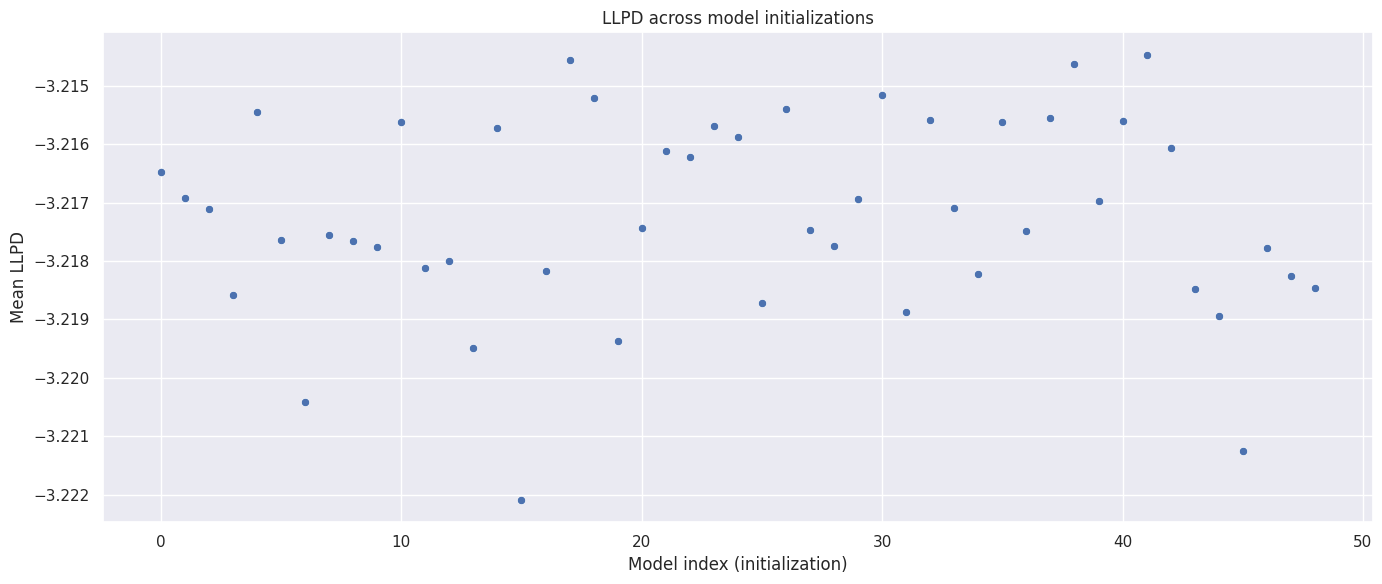

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to DataFrame
df = pd.DataFrame(out, columns=["model_idx", "l", "sp_mean", "sp_var", "llpd", "log_lik"])

# Plot LLPD across initializations
sns.set(rc={'figure.figsize': (14, 6)})
ax = sns.scatterplot(x="model_idx", y="llpd", data=df)

ax.set_xlabel("Model index (initialization)")
ax.set_ylabel("Mean LLPD")
ax.set_title("LLPD across model initializations")

plt.tight_layout()
plt.savefig(figfol + "llpd_scatter.png", dpi=300)
plt.show()

In [ ]:
pkl.dump(out, open('best_model_selected.pkl','wb'))  # save output 
out = pkl.load(open('best_model_selected.pkl','rb'))
outx = pd.DataFrame(out)
outx.columns = ['index','rank','lambda', 'upsilon', 'llpd' ,'Log-likelihood']
outx.head(10)

,index,rank,lambda,upsilon,llpd,Log-likelihood
0,0.0,100.0,0.060596,0.040816,-3.240068,-3.262017
1,1.0,100.0,0.060596,0.040816,-3.243401,-3.263559
2,2.0,100.0,0.060596,0.040816,-3.242221,-3.264069
3,3.0,100.0,0.060596,0.040816,-3.240078,-3.260899
4,4.0,100.0,0.060596,0.040816,-3.241571,-3.262434
5,5.0,100.0,0.060596,0.040816,-3.242202,-3.262935
6,6.0,100.0,0.060596,0.040816,-3.243495,-3.264110
7,7.0,100.0,0.060596,0.040816,-3.243118,-3.264178
8,8.0,100.0,0.060596,0.040816,-3.241822,-3.261233
9,9.0,100.0,0.060596,0.040816,-3.243269,-3.263314


In [7]:
# Get the file name and model output from the best model 
best_setting = outx[outx.iloc[:,4] == outx.iloc[:,4].max()]
i = int(best_setting.loc[:,'index'])
fname_o[i]

'../results/results_op/sensitivity/models/30_73_sample_model_nb_cvtest.pkl'

In [8]:
best_setting

,index,rank,lambda,upsilon,llpd,Log-likelihood
17,17.0,100.0,0.060596,0.040816,-3.239956,-3.261205


<font color=blue>**Our analysis suggest that MEM with seed 66 is most appropriate with highest full data LLPD.** </font>